In [183]:
import os
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [184]:
import numpy as np
import pandas as pd
import time
import pickle
import math
import random
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")
%matplotlib inline

%tensorflow_version 1.0.0
import tensorflow as tf
print(tf.__version__)

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.0.0`. This will be interpreted as: `1.x`.


TensorFlow is already loaded. Please restart the runtime to change versions.
1.15.2


In [185]:
import pandas as pd
import numpy as np
import datetime
import time
from matplotlib import pyplot

# read data from csv file and process X, y
def data_loader(data_path):
    # load raw data
    df = pd.read_csv(data_path)

    # clean data with missing values          
    '''drop the rows directly -> mess up the order
        first 24 rows have pm2.5 value that is NaN -> discard
        else: forward filling'''
    df = df[24:].fillna(method='ffill')

    # integrate 'year', 'month', 'day', 'hour', 'No' as one attribute
    df['time'] = df.apply(lambda x : datetime.datetime(year=x['year'], month=x['month'], day=x['day'], hour=x['hour']), axis=1)
    df.drop(columns=['year', 'month', 'day', 'hour', 'No'], inplace=True)
    df = df.set_index('time')

    # expand "cbwd" into 4 attributes 'SE', 'cv', 'NW', 'NE'
    df = df.join(pd.get_dummies(df['cbwd'])) # one-hot encoding
    del df['cbwd']

    # df = df.drop('cbwd', axis = 1) # remove the attribute temporarily

    X = df.iloc[:,1:].astype(np.float32)
    y = df['pm2.5'].astype(np.float32).to_frame()

    return X, y

# split the data into train, val and test set
from sklearn.model_selection import train_test_split
def train_test_val_split(data, ratio_train, ratio_test, ratio_val):
    X_train, X_middle, y_train, y_middle = train_test_split(data[0], data[1], train_size=ratio_train, test_size=ratio_test + ratio_val, shuffle=True)
    ratio = ratio_val/(1-ratio_train)
    X_val, X_test, y_val, y_test = train_test_split(X_middle, y_middle, train_size=ratio, shuffle=True)
    return (X_train, y_train),(X_val, y_val),(X_test, y_test)

# Z-score normalisation
def data_normalisation(train, val, test):
    X_train, y_train = train[0], train[1]
    X_val, y_val = val[0], val[1]
    X_test, y_test = test[0], test[1]

    mean_x, std_x = X_train.mean(axis=0), X_train.std(axis=0)
    mean_y, std_y = y_train.mean(axis=0), y_train.std(axis=0)

    # Use the mean & std of train. Since there's no way for us to know the future.
    (X_train, y_train) = ((X_train-mean_x)/std_x, (y_train-mean_y)/std_y)
    (X_val, y_val) = ((X_val-mean_x)/std_x, (y_val-mean_y)/std_y) 
    (X_test, y_test) = ((X_test-mean_x)/std_x, (y_test-mean_y)/std_y)

    return (X_train, y_train),(X_val, y_val),(X_test, y_test)

data_path = path = '/content/drive/My Drive/Colab Notebooks/ML/PRSA_data_2010.1.1-2014.12.31.csv'
X, y = data_loader(data_path)

(X_train, y_train),(X_val, y_val),(X_test, y_test) = train_test_val_split((X.values, y.values), 0.8, 0.1, 0.1)
(X_train, y_train),(X_val, y_val),(X_test, y_test) = data_normalisation((X_train, y_train),(X_val, y_val),(X_test, y_test))

# X_train.shape, y_train.shape, X_test.shape, y_test.shape, X_val.shape, y_val.shape


In [186]:
# data_path = path = '/content/drive/My Drive/Colab Notebooks/ML/PRSA_data_2010.1.1-2014.12.31.csv'
# X, y = data_loader(data_path)

# X

In [187]:
#Network parameters
n_input = 10 # 6
n_hidden1, n_hidden2, n_hidden3 = 10, 20, 10
n_output = 1
#Learning parameters 
learning_rate = 0.0001
number_epochs = 10000
mini_batch_size=20

#Defining the input and the output
X_p = tf.placeholder("float", [None, n_input]) 
Y_p = tf.placeholder("float", [None, n_output])

# forward
def multilayer_perceptron(input_d):
    #DEFINING WEIGHTS AND BIASES
    b1 = tf.Variable(tf.random_normal([n_hidden1])) #Biases first hidden layer
    b2 = tf.Variable(tf.random_normal([n_hidden2])) #Biases second hidden layer
    b3 = tf.Variable(tf.random_normal([n_hidden3])) #Biases third hidden layer
    b4 = tf.Variable(tf.random_normal([n_output]))  #Biases output layer
    
    w1 = tf.Variable(tf.random_normal([n_input, n_hidden1]))   #Weights connecting input layer with first hidden layer
    w2 = tf.Variable(tf.random_normal([n_hidden1, n_hidden2])) #Weights connecting first hidden layer with second hidden layer 
    w3 = tf.Variable(tf.random_normal([n_hidden2, n_hidden3])) #Weights connecting second hidden layer with third layer
    w4 = tf.Variable(tf.random_normal([n_hidden3, n_output]))  #Weights connecting third hidden layer with output layer

    layer_1 = tf.nn.relu(tf.add(tf.matmul(input_d, w1), b1)) #Task of neurons of first hidden layer
    layer_2 = tf.nn.relu(tf.add(tf.matmul(layer_1, w2), b2)) #Task of neurons of second hidden layer
    layer_3 = tf.nn.relu(tf.add(tf.matmul(layer_2, w3), b3)) #Task of neurons of thrid layer
    out_layer = tf.add(tf.matmul(layer_3, w4),b4)            #Task of neurons of output layer
    
    return out_layer

# create model
neural_network = multilayer_perceptron(X_p)
# define loss function
loss_op = tf.reduce_mean(tf.math.squared_difference(neural_network,Y_p))
# define optimizer
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss_op)

correct_prediction = tf.equal(tf.argmax(neural_network,1), tf.argmax(Y_p,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction,tf.float32))
# error = np.sqrt(mean_squared_error(neural_network, Y_p))

# initializaing variables
init = tf.global_variables_initializer()

In [188]:
def smooth_loss(epoch,losses,weight=0.85):
    iter = epoch
    loss = losses

    last = loss[0]
    smoothed = []
    for point in loss:
        smoothed_val = last * weight + (1 - weight) * point
        smoothed.append(smoothed_val)
        last = smoothed_val
    return iter, smoothed

In [189]:
neural_network

<tf.Tensor 'Add_99:0' shape=(?, 1) dtype=float32>

- The batch size is a hyperparameter of gradient descent that controls the number of training samples to work through before the model’s internal parameters are updated.
- The number of epochs is a hyperparameter of gradient descent that controls the number of complete passes through the training dataset.

除了梯度本身，批量大小(batchsize)，学习率(learning rate) 这两个因子直接决定了模型的权重更新，从优化本身来看它们是影响模型性能收敛最重要的参数。学习率直接影响模型的收敛状态，batchsize则影响模型的泛化性能，两者又是分子分母的直接关系，相互也可影响，因此这一次来详述它们对模型性能的影响。模型性能对batchsize虽然没有学习率那么敏感，但是在进一步提升模型性能时，batchsize就会成为一个非常关键的参数。

- 大的 batchsize 减少训练时间，提高稳定性
- 大的 batchsize 导致模型泛化能力下降


Epoch:0 Training Loss:142.3852 Test Loss:309.35516
Epoch:100 Training Loss:16.55383 Test Loss:11.428938
Epoch:200 Training Loss:7.4663835 Test Loss:6.5310616
Epoch:300 Training Loss:7.4628544 Test Loss:4.6495395
Epoch:400 Training Loss:3.8859494 Test Loss:3.637967
Epoch:500 Training Loss:3.0529966 Test Loss:3.1019707
Epoch:600 Training Loss:3.270411 Test Loss:2.7207658
Epoch:700 Training Loss:2.986002 Test Loss:2.3869367
Epoch:800 Training Loss:1.9932029 Test Loss:2.147953
Epoch:900 Training Loss:1.6046059 Test Loss:1.9771466
Epoch:1000 Training Loss:1.7247148 Test Loss:1.8226572
Epoch:1100 Training Loss:1.3867631 Test Loss:1.7154045
Epoch:1200 Training Loss:1.3384949 Test Loss:1.6120383
Epoch:1300 Training Loss:2.497846 Test Loss:1.52898
Epoch:1400 Training Loss:1.2140927 Test Loss:1.4629265
Epoch:1500 Training Loss:0.89978737 Test Loss:1.4027321
Epoch:1600 Training Loss:1.4793798 Test Loss:1.3407726
Epoch:1700 Training Loss:0.8591625 Test Loss:1.2864897
Epoch:1800 Training Loss:1.156

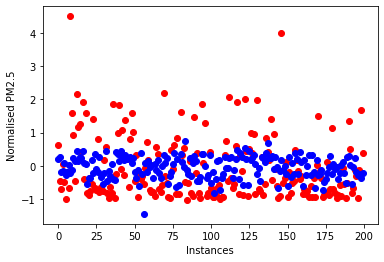

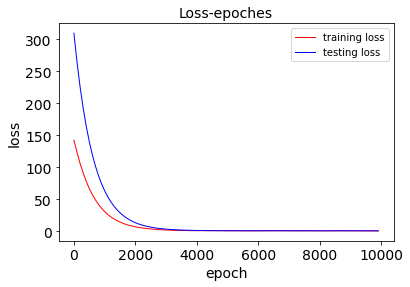

Average precison: 1.0


In [190]:
with tf.Session() as sess: 
    start_time = time.clock()
    sess.run(init)
    train_loss = []
    test_loss = []
    ep = []

    #Training epoch

    possible_indeces = list(range(0, X_train.shape[0]))
    batch_size = 100

    for epoch in range(number_epochs):

        batch_indeces = random.sample(possible_indeces, batch_size)
      
        #get features and respective labels
        batch_X = np.array(X_train[batch_indeces])
        batch_Y = np.array(y_train[batch_indeces])

        sess.run(optimizer, feed_dict={X_p: batch_X, Y_p: batch_Y})
        #Display the epoch
        if epoch % 100 == 0:
            train_acc = accuracy.eval (session = sess, feed_dict = {X_p:batch_X,Y_p:batch_Y})
            val_acc = sess.run(accuracy,feed_dict={X_p:X_val,Y_p:y_val})
            # print("After %d training steps, "
            #       "train accuracy is %s, " 
            #       "validation accuracy is %s " % (epoch, train_acc, val_acc))
            tn_loss = str(sess.run(loss_op, feed_dict={X_p: batch_X, Y_p: batch_Y}))
            tt_loss = str(sess.run(loss_op, feed_dict={X_p: X_test, Y_p: y_test}))
            ep.append(epoch)
            train_loss.append(float(tn_loss))
            test_loss.append(float(tt_loss))
 
            print("Epoch:" + str(epoch) + " Training Loss:" + tn_loss + " Test Loss:" + tt_loss )
    end_time = time.clock()
    print("The totoal training time is: " + str(end_time-start_time))
    
    # Test model
    pred = (neural_network) # Apply softmax to logits 
    # accuracy=tf.keras.losses.MSE(pred,y_test) 
    # print("Accuracy:", accuracy.eval({X: batch_x_train, Y: batch_y_train})) 
    # #tf.keras.evaluate(pred,batch_x)
    # print("Prediction:", pred.eval({X: batch_x_train})) 
    
    output=neural_network.eval({X_p: X_test}) 
    pyplot.plot(y_test[0:200], 'ro', output[0:200], 'bo')
    pyplot.xlabel('Instances') 
    pyplot.ylabel('Normalised PM2.5')
    pyplot.show()

    iter, train_loss = smooth_loss(ep,train_loss)
    iter, test_loss = smooth_loss(ep,test_loss)
    

    plt.plot(iter, train_loss, color='red', label='training loss',linewidth=1)
    plt.plot(iter, test_loss, color='blue', label='testing loss',linewidth=1)  
    plt.title("Loss-epoches", fontsize=14)
    plt.xlabel("epoch", fontsize=14)
    plt.ylabel("loss", fontsize=14)
    plt.tick_params(axis='both', labelsize=14)
    # plt.savefig('./loss_func.png')
    plt.legend()
    plt.show()

    # estimated_class=tf.argmax(pred, 1)#+1e-50-1e-50
    # correct_prediction1 = tf.equal(tf.argmax(pred, 1),y_test)
    # accuracy1 = tf.reduce_mean(tf.cast(correct_prediction1, tf.float32))
    # print("Average precison: " + str(accuracy1.eval({X_p: X_test})))

    accuracy_score = sess.run(accuracy,feed_dict={X_p:X_test,Y_p:y_test})
    print("Average precison: " + str(accuracy_score))